# Sprint22課題 自然言語処理入門

## 1.この課題の目的

- 自然言語処理を体験する
- 簡単な文書の分析ができるようになる

In [0]:
#!pip install janome

In [0]:
import os, sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer

from tqdm import tqdm_notebook as tqdm

from janome.tokenizer import Tokenizer
from janome.analyzer import Analyzer
from janome.charfilter import *
from janome.tokenfilter import *

import Levenshtein

import tensorflow as tf
import keras

import pprint

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
path = "/content/drive/My Drive/My Documents/Study/Programming/DIVE INTO CODE/Class/sprint22"

### 【問題1】BoWとN-gram(手計算)
**目的** ： 古典的かつ強力な手法BoWとN-gramの理解

以下は俳優K.Kさんのつぶやき(コーパス)です。

- 文1: 今撮影中で〜す！
- 文2: 今休憩中で〜す(^^)
- 文3: 今日ドラマ撮影で〜す！
- 文4: 今日、映画瞬公開で〜す！！！

**【問】** 特殊文字除去(!や〜など)、単語分割をし以下の2パターンで文1〜文4を数値化(ベクトル化)してください。

BoW(1-gram)、BoW(2-gram)は手計算の後見やすい形にしてください。


#### サンプル

In [8]:
# 構造化

sample_vocabulary = ["I", "love", "this", "is", "the", "baseball"]
sample_texts = ["I love baseball !!", "I love this !"]
sample_texts_vec = [[1,1,0,0,0,1], [1,1,1,0,0,0]] # 1-gram

df_bow_1gram = pd.DataFrame(data=sample_texts_vec, columns=sample_vocabulary, index=sample_texts)
df_bow_1gram

,I,love,this,is,the,baseball
I love baseball !!,1,1,0,0,0,1
I love this !,1,1,1,0,0,0


#### 実装

In [0]:
# テキストの前処理（単語に分割）
text1 = ["今", "撮影", "中", "です"]
text2 = ["今", "休憩", "中", "です"]
text3 = ["今日", "ドラマ", "撮影", "です"]
text4 = ["今日", "映画", "瞬", "公開", "です"]

In [0]:
texts = [text1, text2, text3, text4]

In [11]:
joined_texts = ["".join(text) for text in texts]
joined_texts

['今撮影中です', '今休憩中です', '今日ドラマ撮影です', '今日映画瞬公開です']

In [12]:
sample = "".join(joined_texts)
sample

'今撮影中です今休憩中です今日ドラマ撮影です今日映画瞬公開です'

In [0]:
def preprocess(texts, n=1, vec=True):
    """
    テキストから単語とIDの辞書を作る関数
    
    Parameters
    ----------
    texts : list
        文書
    
    n : int
        連続して考慮する単語数
    
    ved : boolean
        単語ベクトルを生成する場合はTrue
    
    Returns
    ----------
    vocabulary : list
        単語リスト
    
    word_to_id, id_to_word : dict
        辞書（単語をIDに変換、IDを単語に変換）
    """
    # 単語リスト、辞書の生成
    vocabulary = []
    word_to_id = {}
    id_to_word = {}
    
    print("Now, creating a vocabulary, word_to_id and id_to_word")
    for text in tqdm(texts):
        for i in range(len(text) - n+1):
            words = text[i:i+n] # 文字を抽出
            words = " ".join(words) # 文字を連結
            if words not in vocabulary:                
                vocabulary.append(words)
                new_id = len(word_to_id)
                word_to_id[words] = new_id
                id_to_word[new_id] = words
    
    # 単語ベクトルの生成
    texts_vec = []
    
    if vec == True:
        print("Now, creating texts_vec")
        for text in tqdm(texts):
            text_vec = [0 for i in range(len(vocabulary))]
            for i in range(len(text) - n+1):
                words = text[i:i+n] # 文字を抽出
                words = " ".join(words)
                index = vocabulary.index(words)
                text_vec[index] = 1
            texts_vec.append(text_vec)
    
    return vocabulary, word_to_id, id_to_word, texts_vec

In [0]:
def count_words(vocabulary, texts):
    """
    全テキストから単語リストに含まれる単語の出現回数をカウントする
    
    Paramters
    ----------
    vocabulary : list
        単語リスト
    
    texts : list
        単語分割された文章のリスト
    
    Returns
    ----------
   word_counts : dict
        単語の出現回数
    """
    joined_texts = ["".join(text) for text in texts]
    texts = "".join(joined_texts)
    
    word_counts = {}
    
    for word in tqdm(vocabulary):
        word_counts[word] = texts.count(word)
        
    return word_counts

#### 1-gram

In [15]:
# 前処理（1-gram）
vocabulary1, word_to_id1, id_to_word1, texts_vec1 = preprocess(texts, 1)

Now, creating a vocabulary, word_to_id and id_to_word



Now, creating texts_vec


In [16]:
word_to_id1

{'です': 3,
 'ドラマ': 6,
 '中': 2,
 '今': 0,
 '今日': 5,
 '休憩': 4,
 '公開': 9,
 '撮影': 1,
 '映画': 7,
 '瞬': 8}

In [17]:
vocabulary1, len(texts_vec1[1])

(['今', '撮影', '中', 'です', '休憩', '今日', 'ドラマ', '映画', '瞬', '公開'], 10)

In [18]:
# 構造化
df_bow_1gram = pd.DataFrame(data=texts_vec1, columns=vocabulary1, index=joined_texts)
df_bow_1gram

,今,撮影,中,です,休憩,今日,ドラマ,映画,瞬,公開
今撮影中です,1,1,1,1,0,0,0,0,0,0
今休憩中です,1,0,1,1,1,0,0,0,0,0
今日ドラマ撮影です,0,1,0,1,0,1,1,0,0,0
今日映画瞬公開です,0,0,0,1,0,1,0,1,1,1


In [19]:
count_words(vocabulary1, texts)

{'です': 4,
 'ドラマ': 1,
 '中': 2,
 '今': 4,
 '今日': 2,
 '休憩': 1,
 '公開': 1,
 '撮影': 2,
 '映画': 1,
 '瞬': 1}

#### 2-gram

In [20]:
# 単語ベクトル化（2-gram）
vocabulary2, word_to_id2, id_to_word2, texts_vec2 = preprocess(texts, 2)

Now, creating a vocabulary, word_to_id and id_to_word



Now, creating texts_vec


In [21]:
# 構造化
df_bow_2gram = pd.DataFrame(data=texts_vec2, columns=vocabulary2, index=joined_texts)
df_bow_2gram

,今 撮影,撮影 中,中 です,今 休憩,休憩 中,今日 ドラマ,ドラマ 撮影,撮影 です,今日 映画,映画 瞬,瞬 公開,公開 です
今撮影中です,1,1,1,0,0,0,0,0,0,0,0,0
今休憩中です,0,0,1,1,1,0,0,0,0,0,0,0
今日ドラマ撮影です,0,0,0,0,0,1,1,1,0,0,0,0
今日映画瞬公開です,0,0,0,0,0,0,0,0,1,1,1,1


### 【問題2】TF-IDF(手計算)
目的

- 古典的かつ強力なTF-IDFの理解
標準的なTF-IDFの公式 

**Term Frequency:**

- $tf(t,d) = \frac{n_{t,d}}{\sum_{s \in d}n_{s,d}}$

- $n_{t, d}$ :  文書d内の単語tの出現回数

- $\sum_{s\in d}n_{s, d}$  : 文書$d$の全単語の出現回数の和

**Inverse Document Frequency:**

- $idf(t) = \log_2{\frac{N}{df(t)}}$

- $N$ : 全文書数

- $df(t)$：単語$t$が出現する文書数


**TF-IDF:**

- $tfidf(t, d) = tf(t, d) \times idf(t)$

【問】
- 問題1のコーパスを使って、文1〜文4をTFIDFで数値化(ベクトル化)すること。 

- 問題1と同様、手計算の後見やすい形にする。

**正解例** : tfidf(今, 文書1) = 0.25 となる。

In [0]:
def tfidf(texts, vocabulary):
    """
    TF-IDF
        
    Parameters
    ----------
    texts : list
        文書
    
    vocabulary : list
        単語リスト
    
    Returns
    ----------
    tf_idfs : list
        TF-IDF
    """
    N = len(texts) # 全文書数
    
    tf_idfs = [] # TF-IDFを格納するリスト
    idft_s = {} # idf(t)を格納する辞書
    
    # IDF
    for word in vocabulary:
        count = 0
        for text in texts:
            if word in text:
                count += 1
        idft_s[word] = np.log2(N/count)

    # TF-IDF
    for text in texts:
        tf_idf = [0 for i in range(len(vocabulary))]
        for word in vocabulary:
            if word in text:
                n_td = text.count(word)            # 文書内の単語の出現回数
                sum_of_words = len(text)         # 文書内の全単語の出現回数の和
                tf = n_td / sum_of_words         # Term_frequency
                idf = idft_s[word]                        # wordに関するidf 
                index = vocabulary.index(word) # 単語のインデックス
                tf_idf[index] = tf*idf
        tf_idfs.append(tf_idf)
        
    return tf_idfs

In [0]:
tf_idf = tfidf(texts, vocabulary1)

In [24]:
# 構造化
df_tfitf = pd.DataFrame(data=tf_idf, columns=vocabulary1, index=joined_texts)
df_tfitf

,今,撮影,中,です,休憩,今日,ドラマ,映画,瞬,公開
今撮影中です,0.25,0.25,0.25,0.0,0.0,0.00,0.0,0.0,0.0,0.0
今休憩中です,0.25,0.00,0.25,0.0,0.5,0.00,0.0,0.0,0.0,0.0
今日ドラマ撮影です,0.00,0.25,0.00,0.0,0.0,0.25,0.5,0.0,0.0,0.0
今日映画瞬公開です,0.00,0.00,0.00,0.0,0.0,0.20,0.0,0.4,0.4,0.4


- 文書１（今撮影中です）に対して、tf_idf(今、文書１)が0.25となっている。

### 【問題3】テキストクリーニング(プログラミング)
目的

- 実データ対応のためのテキストクリーニングの理解
- 正規表現の理解

実際のテキストデータは非常に汚いことが多い。 
以下は3/6(水)にnoroさんがSlackで発言した文章で、良い例。

---
<!everyone> *【スペシャル特典】有償のRubyMineやPyCharmの `6ヶ月間100%OFFクーポン` をご希望者の方先着100名様に贈呈いたします！*\n\nこの度、RubyMineやPyCharmのメーカーであるJetBrains社へのクーポンコードの提供交渉が実り、100クーポンをいただくことができました。\n\n```\nRubyMine\n<https://www.jetbrains.com/ruby/>\n\nPyCharm\n<https://www.jetbrains.com/pycharm/>\n```\n\n「ご希望の方は、手を挙げて！」方式で、ご希望の方はこの投稿の手あげスタンプをクリックしてください。\n\n期限は、 *`2019年3月20日（水）22:00まで`* とさせていただきます。\nふるってのご希望をお待ちしております！ :smile:

---

【問】
このテキストに以下の処理を施す。

- urlを削除
- 【〇〇】を削除
- 改行等の特殊文字を削除
- 絵文字除去

数字を文字列NUMBERに置き換える処理を行うことが多い。

---
有償のRubyMineやPyCharmの6ヶ月間100%OFFクーポンをご希望者の方先着100名様に贈呈いたします！この度、RubyMineやPyCharmのメーカーであるJetBrains社へのクーポンコードの提供交渉が実り、100クーポンをいただくことができました。RubyMinePyCharm「ご希望の方は、手を挙げて！」方式で、ご希望の方はこの投稿の手あげスタンプをクリックしてください。期限は、2019年3月20日（水）22:00までとさせていただきます。ふるってのご希望をお待ちしております！

---

#### Tips NLPのLinuxコマンド
これまでpythonでファイルを読み込んで処理をしたが、簡単な作業においてはlinuxコマンドの方がメモリの使用料が半分以下だったりとパフォーマンスが良い。

例えばファイルの行数を数えたい場合、pythonでわざわざ書くのは面倒である。

以下の1行のコマンドで実行できます。

**wc -l 〇〇.txt**

また、
- 分割したい場合はsplit
- 並び替えたい場合はsort
- 置換にはsed
- 文の先頭、後頭部分を見たければhead,tail

など便利なコマンドがある。

詳しく知りたい場合は、NLP100本ノックで調べてみること。

#### 正規表現のサンプル

In [25]:
# 正規表現操作のライブラリ
import re
# 対象テキストデータ
sample_text = '【スペシャル特典】有償のRubyMineやPyCharmの `6ヶ月間100%OFFクーポン` をご希望者の方先着100名様に贈呈いたします！*\n\n'
# re.compileを使うと処理が早くなります
BAD_SYMBOL = re.compile('[\n*！`]+')
# re.sub(r'[\n*！`]+', '', text)でもできます
sample_text = re.sub(BAD_SYMBOL, '', sample_text)
sample_text

'【スペシャル特典】有償のRubyMineやPyCharmの 6ヶ月間100%OFFクーポン をご希望者の方先着100名様に贈呈いたします'

#### 実装

In [0]:
text = "<!everyone> *【スペシャル特典】有償のRubyMineやPyCharmの `6ヶ月間100%OFFクーポン` をご希望者の方先着100名様に贈呈いたします！*\n\nこの度、RubyMineやPyCharmのメーカーであるJetBrains社へのクーポンコードの提供交渉が実り、100クーポンをいただくことができました。\n\n```\nRubyMine\n<https://www.jetbrains.com/ruby/>\n\nPyCharm\n<https://www.jetbrains.com/pycharm/>\n```\n\n「ご希望の方は、手を挙げて！」方式で、ご希望の方はこの投稿の手あげスタンプをクリックしてください。\n\n期限は、 *`2019年3月20日（水）22:00まで`* とさせていただきます。\nふるってのご希望をお待ちしております！ :smile:"

In [27]:
text

'<!everyone> *【スペシャル特典】有償のRubyMineやPyCharmの `6ヶ月間100%OFFクーポン` をご希望者の方先着100名様に贈呈いたします！*\n\nこの度、RubyMineやPyCharmのメーカーであるJetBrains社へのクーポンコードの提供交渉が実り、100クーポンをいただくことができました。\n\n```\nRubyMine\n<https://www.jetbrains.com/ruby/>\n\nPyCharm\n<https://www.jetbrains.com/pycharm/>\n```\n\n「ご希望の方は、手を挙げて！」方式で、ご希望の方はこの投稿の手あげスタンプをクリックしてください。\n\n期限は、 *`2019年3月20日（水）22:00まで`* とさせていただきます。\nふるってのご希望をお待ちしております！ :smile:'

In [0]:
# URLを削除
url_regex = re.compile(r"\<.+?\>")

# 【●●】を削除
brackets_regex = re.compile(r"\【.+?\】")

# 改行等の特殊文字(Special character)を削除
spec_regex = re.compile(r"[\n*`]")

# 絵文字除去
emoji_regex = re.compile(r"\:[^0-90-9]+\:")

# 正規表現まとめ
regexes = [url_regex, brackets_regex, spec_regex, emoji_regex]

- <font color="blue">**.+?**</font>  ： （改行以外の）任意の文字のグループを抽出する
   - <font color="blue">**.**</font> : 改行文字以外の任意の１文字とマッチする。
   - <font color="blue">**+**</font> : 直前のグループの１回以上の出現にマッチする。
   - <font color="blue">**?**</font> : 直前のグループの0回か1回の出現にマッチする。
   
- f"{condition1}|{condition2}|{condition3}|{condition4}"

In [0]:
# クリーニング
for regex in regexes:
    text = regex.sub("", text)

In [30]:
text

' 有償のRubyMineやPyCharmの 6ヶ月間100%OFFクーポン をご希望者の方先着100名様に贈呈いたします！この度、RubyMineやPyCharmのメーカーであるJetBrains社へのクーポンコードの提供交渉が実り、100クーポンをいただくことができました。RubyMinePyCharm「ご希望の方は、手を挙げて！」方式で、ご希望の方はこの投稿の手あげスタンプをクリックしてください。期限は、 2019年3月20日（水）22:00まで とさせていただきます。ふるってのご希望をお待ちしております！ '

- 適切な処理が行われていることを確認した。

### 【問題4】形態素解析

**目的**

- 形態素解析の理解

形態素解析のツールはMecabやJanomeなど様々だが、ここでは手軽に導入できるJanomeを使う。

[Janome document](https://mocobeta.github.io/janome/)

【問】上記のクリーニングしたテキストをJanomeを用いて形態素解析し、名詞または動詞の単語を抜き出すこと。

**正解例 : ["有償", "RubyMine", "Pycharm", ...]



In [0]:
tokenizer = Tokenizer()

In [0]:
tokens = tokenizer.tokenize(text)

#### トークンの内容を確認する

In [33]:
for token in tokens:
    print(token)

有償	名詞,一般,*,*,*,*,有償,ユウショウ,ユーショー
の	助詞,連体化,*,*,*,*,の,ノ,ノ
RubyMine	名詞,一般,*,*,*,*,RubyMine,*,*
や	助詞,並立助詞,*,*,*,*,や,ヤ,ヤ
PyCharm	名詞,一般,*,*,*,*,PyCharm,*,*
の	助詞,連体化,*,*,*,*,の,ノ,ノ
 	記号,空白,*,*,*,*, ,*,*
6	名詞,数,*,*,*,*,6,*,*
ヶ月	名詞,接尾,助数詞,*,*,*,ヶ月,カゲツ,カゲツ
間	名詞,接尾,一般,*,*,*,間,カン,カン
100	名詞,数,*,*,*,*,100,*,*
%	名詞,サ変接続,*,*,*,*,%,*,*
OFF	名詞,一般,*,*,*,*,OFF,*,*
クーポン	名詞,一般,*,*,*,*,クーポン,クーポン,クーポン
 	記号,空白,*,*,*,*, ,*,*
を	助詞,格助詞,一般,*,*,*,を,ヲ,ヲ
ご	接頭詞,名詞接続,*,*,*,*,ご,ゴ,ゴ
希望	名詞,サ変接続,*,*,*,*,希望,キボウ,キボー
者	名詞,接尾,一般,*,*,*,者,シャ,シャ
の	助詞,連体化,*,*,*,*,の,ノ,ノ
方	名詞,非自立,一般,*,*,*,方,ホウ,ホー
先着	名詞,サ変接続,*,*,*,*,先着,センチャク,センチャク
100	名詞,数,*,*,*,*,100,*,*
名	名詞,接尾,助数詞,*,*,*,名,メイ,メイ
様	名詞,接尾,人名,*,*,*,様,サマ,サマ
に	助詞,格助詞,一般,*,*,*,に,ニ,ニ
贈呈	名詞,サ変接続,*,*,*,*,贈呈,ゾウテイ,ゾーテイ
いたし	動詞,非自立,*,*,五段・サ行,連用形,いたす,イタシ,イタシ
ます	助動詞,*,*,*,特殊・マス,基本形,ます,マス,マス
！	記号,一般,*,*,*,*,！,！,！
この	連体詞,*,*,*,*,*,この,コノ,コノ
度	名詞,非自立,副詞可能,*,*,*,度,タビ,タビ
、	記号,読点,*,*,*,*,、,、,、
RubyMine	名詞,固有名詞,組織,*,*,*,RubyMine,*,*
や	助詞,並立助詞,*,*,*,*,や,ヤ,ヤ
PyCharm	名詞,一般,*,*,*,*,PyCharm,*,*
の	助詞,連体化,*,*,*,*

#### 名詞、動詞以外を除外する

In [34]:
# 除外する品詞
FILTER = ['記号','助詞',"助動詞","連体詞", "接頭詞"]

char_filters = [UnicodeNormalizeCharFilter()]

token_filters = [CompoundNounFilter(), POSStopFilter(FILTER), LowerCaseFilter()]

a = Analyzer(char_filters, tokenizer, token_filters)

# 名詞、動詞を抽出する
for token in a.analyze(text):
    print(token)

有償	名詞,一般,*,*,*,*,有償,ユウショウ,ユーショー
rubymine	名詞,一般,*,*,*,*,rubymine,*,*
pycharm	名詞,一般,*,*,*,*,pycharm,*,*
6ヶ月間100%offクーポン	名詞,複合,*,*,*,*,6ヶ月間100%offクーポン,*カゲツカン***クーポン,*カゲツカン***クーポン
希望者	名詞,複合,*,*,*,*,希望者,キボウシャ,キボーシャ
方先着100名様	名詞,複合,*,*,*,*,方先着100名様,ホウセンチャク*メイサマ,ホーセンチャク*メイサマ
贈呈	名詞,サ変接続,*,*,*,*,贈呈,ゾウテイ,ゾーテイ
いたし	動詞,非自立,*,*,五段・サ行,連用形,いたす,イタシ,イタシ
!	名詞,サ変接続,*,*,*,*,!,*,*
度	名詞,非自立,副詞可能,*,*,*,度,タビ,タビ
rubymine	名詞,固有名詞,組織,*,*,*,rubymine,*,*
pycharm	名詞,一般,*,*,*,*,pycharm,*,*
メーカー	名詞,一般,*,*,*,*,メーカー,メーカー,メーカー
jetbrains社	名詞,複合,*,*,*,*,jetbrains社,*シャ,*シャ
クーポンコード	名詞,複合,*,*,*,*,クーポンコード,クーポンコード,クーポンコード
提供交渉	名詞,複合,*,*,*,*,提供交渉,テイキョウコウショウ,テイキョーコーショー
実り	動詞,自立,*,*,五段・ラ行,連用形,実る,ミノリ,ミノリ
100クーポン	名詞,複合,*,*,*,*,100クーポン,*クーポン,*クーポン
いただく	動詞,自立,*,*,五段・カ行イ音便,基本形,いただく,イタダク,イタダク
こと	名詞,非自立,一般,*,*,*,こと,コト,コト
でき	動詞,自立,*,*,一段,連用形,できる,デキ,デキ
rubyminepycharm	名詞,一般,*,*,*,*,rubyminepycharm,*,*
希望	名詞,サ変接続,*,*,*,*,希望,キボウ,キボー
方	名詞,非自立,一般,*,*,*,方,ホウ,ホー
手	名詞,一般,*,*,*,*,手,テ,テ
挙げ	動詞,自立,*,*,一段,連用形,挙げる,アゲ,アゲ
!」方式	名詞,複合,*,*,*,*,!」方式,*ホウシキ,*ホー

- 名詞、動詞が抽出されていることを確認した。

### 【問題5】ニュースの分析

**目的**

- 日本語の自然言語処理の体験
- 類似度の理解

以下からldcc-20140209.tar.gzをダウンロードする。 

[livedoor](https://www.rondhuit.com/download.html#ldcc)

---
livedoorのnewsをダウンロード

[wget](https://www.rondhuit.com/download/ldcc-20140209.tar.gz)

圧縮ファイルを解凍

tar zxf ldcc-20140209.tar.gz

livedoorニュースの説明を表示

cat text/README.txt

---

もしくはwgetコマンドを使っても良い。

【問】
以下の流れでニュースを分析すること。

- まずどんなニュースなのか読む
- 出現単語をカウントして分析する
- テキストをクリーニングする
- BoW + TFIDFでベクトル化する
- あるニュースに一番cos類似度が近いニュースを出力する関数の作成
- 別の類似度手法を1つ調べて上の関数に組み込む(切り替えられるようにする)
- なぜそのような結果になったのか考察する

 [sklearn.feature_extraction.text](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

In [0]:
os.chdir(path)

In [0]:
# サブフォルダを含めて読み込む
from sklearn.datasets import load_files

In [0]:
bin_data = load_files('./text', encoding='utf-8')
documents = bin_data.data
# 今回はラベルが無いと仮定する
# targets = bin_data.target

In [38]:
# 7376本のニュースが格納されている
type(documents), len(documents)

(list, 7376)

In [0]:
# textを抽出する
news_text = ""

In [0]:
for i in range(len(documents)):
    news_text += documents[i]

In [41]:
news_text[:100]

'http://news.livedoor.com/article/detail/4931238/\n2010-08-08T10:00:00+0900\nNY名物イベントが日本でも！名店グルメを気軽に楽しむ'

#### ニュースを読む

In [42]:
#  サンプル
documents[:2]

['http://news.livedoor.com/article/detail/4931238/\n2010-08-08T10:00:00+0900\nNY名物イベントが日本でも！名店グルメを気軽に楽しむ\nニューヨークで20年続いている食の祭典「レストラン・ウィーク」。その日本版がダイナーズクラブ特別協賛のもと7月30日よりスタート。8月31日までの期間中、青山・六本木、丸の内、銀座、横浜のエリアから、ラグジュアリーレストラン81店舗がこのイベントのために特別用意したランチメニュー2010円（税・サ別）、ディナー5000円（税・サ別）を気軽に楽しめる、とっておきのイベントです。\n\u3000\n\u3000実行委員長には、学校法人服部学園、服部栄養専門学校 理事長・校長であり医学博士でもある服部幸應氏を迎え、実行委員に石田純一さん、LA BETTOLAオーナーシェフ落合務氏、フードアナリスト協会会長、高賀右近氏、つきぢ田村三代目、田村隆氏に、そして放送作家・脚本家の小山薫堂さんなど、食のスペシャリストたちが勢揃い。\n\n参加レストランには、ミシュランのフランス版、東京版ともに星を獲得している吉野建シェフの「レストラン タテル ヨシノ 汐留」や、日本料理の名門「つきぢ田村」、「金田中 庵」、「赤坂璃宮」に「mikuni MARUNOUCHI」など、日本を代表するレストランがずらり。\n\u3000イベント期間の〜8月19日までは、特別協賛のダイナーズクラブカード会員、またはシティバンクに口座を持つシティゴールドメンバーが楽しめる先行期間となりますが、その後は誰でも参加できるので、日程のチェックは必須。\n\n\u3000予約方法は必ず事前に、各店舗に問合せを行い「ジャパンレストラン・ウィーク2010」での予約であることを伝えればOK！憧れていたレストランの料理をリーズナブルにいただけるチャンスです！極上の味とラグジュアリーな空間を満喫。そんな幸せを実感できる「ジャパンレストラン・ウィーク2010」にぜひ参加しててみてはいかがですか？\n\nJAPAN RESTAURANT WEEK 2010 -公式サイト\n',
 'http://news.livedoor.com/article/detail/6655079/\n2012-06-13T19:25:00+0

#### 出現単語をカウントする

In [0]:
from janome.tokenizer import Tokenizer
import collections

t = Tokenizer()

In [0]:
# 単語をカウントする
c = collections.Counter(t.tokenize(news_text, wakati=True))

In [45]:
# 出現頻度が高い順に表示
mc = c.most_common()
print(mc[:20])

[('の', 207059), ('、', 206233), ('。', 136138), ('に', 131630), ('を', 126780), ('が', 116333), ('は', 112063), ('て', 101450), ('で', 84560), ('た', 83900), ('\n', 83135), (' ', 79600), ('と', 76650), ('「', 63160), ('」', 62505), ('し', 62486), ('\n\n', 51576), ('も', 47548), ('・', 41657), ('な', 36142)]


- （予想通りではあるが）助詞や改行文字の出現頻度が高い。

#### テキストクリーニングする

In [0]:
# URLを削除
regex_1 = re.compile(r"http(s)?://([\w-]+\.)+[\w-]+(/[\w ./?%&=]*)?")

# \\n\\u3000
regex_3 = re.compile("\\n(?:\\u3000)?")

# 時刻
regex_2 = re.compile(r"201(?:\d-\d-\d\S\d\d:\d\d|\d-\d\d-\d\d\S\d\d:\d\d):\d\d\+0900")

# 正規表現まとめ
regexes = [regex_1, regex_2, regex_3]

In [0]:
# テキストクリーニング後のテキスト
re_documents = []

for i in range(len(documents)):
    tmp = documents[i]
    tmp = regex_1.sub("", tmp)
    tmp = regex_2.sub("", tmp)
    tmp = regex_3.sub("", tmp)
    re_documents.append(tmp)

In [48]:
re_documents[:3]

['NY名物イベントが日本でも！名店グルメを気軽に楽しむニューヨークで20年続いている食の祭典「レストラン・ウィーク」。その日本版がダイナーズクラブ特別協賛のもと7月30日よりスタート。8月31日までの期間中、青山・六本木、丸の内、銀座、横浜のエリアから、ラグジュアリーレストラン81店舗がこのイベントのために特別用意したランチメニュー2010円（税・サ別）、ディナー5000円（税・サ別）を気軽に楽しめる、とっておきのイベントです。実行委員長には、学校法人服部学園、服部栄養専門学校 理事長・校長であり医学博士でもある服部幸應氏を迎え、実行委員に石田純一さん、LA BETTOLAオーナーシェフ落合務氏、フードアナリスト協会会長、高賀右近氏、つきぢ田村三代目、田村隆氏に、そして放送作家・脚本家の小山薫堂さんなど、食のスペシャリストたちが勢揃い。参加レストランには、ミシュランのフランス版、東京版ともに星を獲得している吉野建シェフの「レストラン タテル ヨシノ 汐留」や、日本料理の名門「つきぢ田村」、「金田中 庵」、「赤坂璃宮」に「mikuni MARUNOUCHI」など、日本を代表するレストランがずらり。イベント期間の〜8月19日までは、特別協賛のダイナーズクラブカード会員、またはシティバンクに口座を持つシティゴールドメンバーが楽しめる先行期間となりますが、その後は誰でも参加できるので、日程のチェックは必須。予約方法は必ず事前に、各店舗に問合せを行い「ジャパンレストラン・ウィーク2010」での予約であることを伝えればOK！憧れていたレストランの料理をリーズナブルにいただけるチャンスです！極上の味とラグジュアリーな空間を満喫。そんな幸せを実感できる「ジャパンレストラン・ウィーク2010」にぜひ参加しててみてはいかがですか？JAPAN RESTAURANT WEEK 2010 -公式サイト',
 '小沢一郎氏の妻が支援者に離婚を報告。「週刊文春」報じる13日、Web版「週刊文春」は、民主党の元代表・小沢一郎氏の妻が、支援者宛に離婚したことを伝える手紙を送ったと報じ、ツイッターやネット掲示板で大きな話題になっている。記事によると、その手紙は「小沢は放射能が怖くて秘書と一緒に逃げだしました」「隠し子が発覚した際、小沢元代表は和子夫人に謝るどころか、『いつでも離婚してやる』と言い放ち

- 概ね日常的な文章に整形されたと考える。

#### BoW + TFIDFでベクトル化する

In [0]:
from sklearn.feature_extraction.text import CountVectorizer as CV
from sklearn.feature_extraction.text import TfidfVectorizer as TV

In [0]:
# 200本に1本
cv = CV(min_df=0.001)

In [0]:
matrix = cv.fit_transform(re_documents)

In [61]:
matrix.shape

(7376, 5244)

In [0]:
X1 = matrix.toarray()

In [64]:
X1.shape

(7376, 5244)

In [0]:
tv = TV(min_df=0.001)

In [0]:
tfidf = tv.fit_transform(re_documents)

In [0]:
X2 = matrix.toarray()

In [66]:
X2.shape

(7376, 5244)

#### あるニュースに一番cos類似度が近いニュースを出力する関数の作成

In [0]:
cos = cosine_similarity(X1, X1)

In [126]:
cos[0].argsort()[-2]

3032

In [0]:
from sklearn.metrics.pairwise import cosine_similarity

def find_similar_news(index, texts, mode="cos"):
  """
  最もコサイン類似度が近いテキストを出力する関数
  
  Parameters
  ---------
  index : int
    類似度を評価するテキストのインデックス
  
  word_vec : 次の形のndarray, shape(samples)
    単語ベクトル
    
  texts : list
    テキスト
    
  mode : str
    コサイン類似度（cos） or 
  """
  
  if mode == "cos":
    word_vec = CV(min_df=0.001).fit_transform(texts).toarray() # 単語ベクトルに変換（BoW)
    cos_matrix = cosine_similarity(word_vec, word_vec) # コサイン類似度のマトリックス
    cos_similarity = cos_matrix[index]  #コサイン類似度
    similar_text_index = cos_similarity.argsort()[-2] # 類似度が最も近いテキストのインデックス（自身との類似度が最大なので2番目のインデックスを取る）
    return texts[similar_text_index]
  
  elif mode == "lev":
    distances = np.zeros(len(texts))
    
    # 指定したテキストと他のテキスト間のレーベンシュタイン距離を計算する
    for i in range(len(texts)):
      distances[i] = Levenshtein.distance(texts[index], texts[i])
    
    similar_text_index = distances.argsort()[-2]
    
    return texts[similar_text_index]

#### 別の類似度手法を1つ調べて上の関数に組み込む(切り替えられるようにする)

- 具体的な指標として、"編集距離 (Levenshtein Distance)"が存在する。

- 編集距離とは、具体的に編集（挿入・削除・置換の3種類）が1回行われるごとに距離を1つ増やすもの。

- レーベンシュタイン距離(Levenshtein distance)は、最低限の編集回数で済むような編集の組み合わせを基準にして編集距離を計算する。

In [111]:
#!pip install python-Levenshtein

     |████████████████████████████████| 51kB 2.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/de/c2/93/660fd5f7559049268ad2dc6d81c4e39e9e36518766eaf7e342
Successfully built python-Levenshtein


#### 類似テキストの探索（コサイン類似度）

In [0]:
# 類似度を測りたいテキストのインデックス
target = 2

In [0]:
# 類似度の高い記事
similar_cos = find_similar_news(target, re_documents)

In [132]:
print(similar_cos)
print(re_documents[target])

【Sports Watch】三浦ファン、ほしのあきを“さげまん”呼ばわり22日（月）発売の「週刊アサヒ芸能」（12.2号）では、「ほしのあき 三浦皇成結婚を阻む『さげまんボディ』『スランプの責任を押し付けられて…』」との見出しで、騎手・三浦皇成とグラビアタレント・ほしのあきの交際について、その周辺レポートを掲載した。新人年間最多勝（91勝）に最速100勝を挙げた次世代のスーパージョッキーだが、近年、失速感は否めない戦績に終始している。同誌にコメントを寄せるスポーツ紙のデスクは、「今の三浦は、もう『武豊2世』じゃない。G1制覇と言っても、そのクラスのお手馬は数頭だけ。代役で一発という寂しい状況です」と語っており、美浦TC関係者も「昨年9月、英国で初騎乗初勝利するも、ほしのとの交際が1年目を迎えて、状況が一変した。恩師の河野通文調教師と袂を分かち、フリー宣言をしてから急降下。今年1月の落馬事故も影響し、東西リーディング29位（11月14日現在）と低迷している。三浦ファンがほしのを“さげまん”と呼ぶ気持ちも納得できます」と話している。また、二人の来春結婚の噂について、前出のデスクは、「三浦の両親が最後の難関でしょう。父親との絆が深く、通常では考えられないフリー宣言を勧めたのも両親と聞いています。その父親が13歳の年の差婚をすんなりと認めてくれるかどうか…」という見解を示しており、すんなりとはいきそうにない現状をうかがわせた。・週刊アサヒ芸能 ［ライト版］＜デジタル＞（PC版）・週刊アサヒ芸能（モバイル版）
【Sports Watch】田中＆里田の交際、アプローチは里田からグラビアアイドル・ほしのあき＆騎手・三浦皇成がお互いのブログで交際を認めた日、東北楽天ゴールデンイーグルスのエース・田中将大とタレント・里田まいの交際もまた公のものとなったが、本日30日（火）発売の「週刊アサヒ芸能」（12.9号）では、「マー君を“ナンパ”した里田」との見出しで、両者の交際にまつわる関係者の証言を紹介した。同誌にコメントを寄せた芸能デスクによると、「周囲の事情はさておき、当人たちが盛り上がっているのは確か。結婚も完全に視野に入れているようで、すでに新居を探しているとの話まである」という。また、二人の交際は里田からのアプローチによるものとのことで、前出の芸能デスクは、「2人は昨年末の番組共演

#### 考察

- 両記事ともに恋愛関係であり、＜交際＞という単語が含まれていることからも、類似度が高いと判定されていると思われる。

#### 参考：類似テキストの探索（レーベンシュタイン距離）

In [0]:
# 類似度の高い記事
similar_lev = find_similar_news(target, re_documents, mode="lev")

In [137]:
similar_lev

'iPhone女子部がフリーペーパー「iPhone♡」を大手量販店やソフトバンクショップで配布開始iPhone女子に向けた「iPhone♡」ができました！ iPhone女子部は、フリーペーパー「iPhone♡(アイフォーン ラブ)」を31日から大手量販店やソフトバンクショップの店舗で配布を開始した。iPhoneを利用する女性向けにiPhoneの便利な活用法やアプリの紹介、周辺機器やグッズの紹介などを32ページに渡って紹介している。発行部数は10万部。iPhone女子部発足のきっかけになったムック本『はじめまして。iPhone』以降、2011年2月配布のフリーペーパー『こんにちは、iPhone』、同年9月配布のフリーペーパー第2弾『ごきげんよう。iPhone』に続いてフリーペーパ第3弾となるiPhone♡は定期刊行していく予定だという。iPhone♡創刊号の表紙iPhone女子部のサイトで知らせている配布店舗は以下の通り。【ヨドバシカメラ】ソフトバンクヨドバシ梅田／ソフトバンクヨドバシＡＫＩＢＡ／ソフトバンクヨドバシ横浜／ソフトバンクヨドバシ京都／ソフトバンクステージヨドバシ新宿西口本店／ソフトバンクヨドバシ吉祥寺／ソフトバンクステージヨドバシ川崎／ソフトバンクステージヨドバシ町田／ソフトバンクヨドバシカメラ博多／ソフトバンクステージヨドバシ錦糸町／ソフトバンクヨドバシ札幌／ソフトバンクステージヨドバシ仙台／ソフトバンクステージヨドバシ千葉／ソフトバンクステージヨドバシ新宿東口ケータイ総合館／ソフトバンクステージヨドバシ上野／ソフトバンクステージヨドバシ京急上大岡（９階）／株式会社ヨドバシカメラマルチメディア宇都宮／株式会社ヨドバシカメラ八王子店Ｍ１【ヤマダ電機】ＬＡＢＩ\u3000１\u3000日本総本店\u3000池袋／ソフトバンクステージＬＡＢＩ新宿東口館／ＬＡＢＩ\u3000渋谷店／ソフトバンクステージＬＡＢＩ新宿西口／ソフトバンクステージＬＡＢＩ１モバイルドリーム館／ソフトバンクＬＡＢＩ１ＮＡＭＢＡ／ソフトバンクステージＬＡＢＩ品川大井町／ソフトバンクステージＬＡＢＩ１高崎／ソフトバンクステージＬＡＢＩ三宮／ソフトバンクステージＬＡＢＩ上大岡／テックランド坂戸店／ソフトバンクステージＬＡＢＩ千里／ソフトバンクステージＬＡＢＩ津田沼／テックランドＮｅｗ港北セン

### 【問題6】感情分析

**目的**

- NLP定番の感情分析の経験
- 英語の処理の実践

#### 【問】
IMDBという映画に対するレビューのデータセットを使う。

良いレビューか悪いレビューかを判定するモデルを作成すること。

#### データの説明

1. Overview

 - This dataset contains movie reviews along with their associated binary sentiment polarity labels. 
 - It is intended to serve as a benchmark for sentiment classification. This document outlines how the dataset was gathered, and how to use the files provided. 


2. Dataset 

 - The core dataset contains 50,000 reviews split evenly into 25k train and 25k test sets. The overall distribution of labels is balanced (25k pos and 25k neg). We also include an additional 50,000 unlabeled documents for unsupervised learning. 
 
 - In the entire collection, no more than 30 reviews are allowed for any given movie because reviews for the same movie tend to have correlated ratings. Further, the train and test sets contain a disjoint set of movies, so no significant performance is obtained by memorizing movie-unique terms and their associated with observed labels.  
 - <font color="blue">In the labeled train/test sets, a negative review has a score <= 4 out of 10, and a positive review has a score >= 7 out of 10. </font> 
 - Thus reviews with more neutral ratings are not included in the train/test sets. In the unsupervised set, reviews of any rating are included and there are an even number of reviews > 5 and <= 5.


#### 前提条件

In [0]:
vocab_size = 10000 # 出現頻度の順に10000個を取得
features = 16 # 埋め込む空間

#### データセットの準備

In [0]:
# IMDB datasetのダウンロード
imdb = tf.keras.datasets.imdb

# 訓練データ中に出てくる単語のうち、最も頻繁に出現吸える10,000個を保持する
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=vocab_size)

#### データセットの確認

In [0]:
print("train_data_type : {}".format(type(train_data)))
print("len : {}".format(len(train_data)))
print("")
print("test_data_type : {}".format(type(test_data)))
print("len : {}".format(len(test_data)))

train_data_type : <class 'numpy.ndarray'>
len : 25000

test_data_type : <class 'numpy.ndarray'>
len : 25000


In [0]:
# 単語をIDに変換する辞書
word_index = imdb.get_word_index()

In [0]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [0]:
# インデックスの最初の方は予約済み
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [0]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                       value=word_index["<PAD>"],
                                                       padding="post",
                                                       maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding="post",
                                                       maxlen=256)

#### モデルの構築

#### 学習

In [0]:
model = keras.Sequential()

model.add(keras.layers.Embedding(vocab_size, 64)) # 単語埋め込み
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation="relu"))
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 64)          640000    
_________________________________________________________________
global_average_pooling1d_6 ( (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 17        
Total params: 641,057
Trainable params: 641,057
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.01),
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [0]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [ ]:
history = model.fit(partial_x_train, partial_y_train,
                     epochs=40,
                     batch_size=512,
                     validation_data=(x_val, y_val),
                     verbose=1)

In [0]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

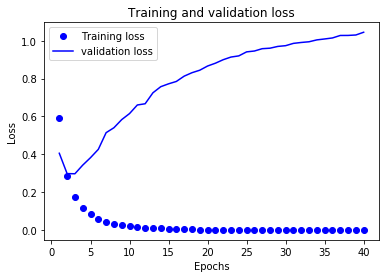

In [0]:
# ロス、正解率を可視化する

acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

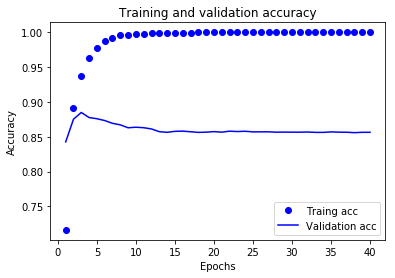

In [0]:
plt.clf()
acc_values = history_dict["acc"]
val_acc_values = history_dict["val_acc"]

plt.plot(epochs, acc, "bo", label="Traing acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### テストデータを用いた予測

In [0]:
results = model.evaluate(test_data, test_labels)

25000/25000 [==============================] - 1s 45us/step


In [0]:
print("Loss : ", results[0])
print("Accuracy : ", results[1])

Loss :  1.1387948656749725
Accuracy :  0.84188


- 正解率は約85%となった。

- 学習曲線からはモデルが過剰適合している様子が見てとれるため、early-stoppingしても良いかもしれない。

### 【問題8】自然言語処理の応用事例

**目的**

- NLPの情報共有

現在自然言語処理はどのような企業でどのように活用されているか？ （1つ例をあげて3~5分で発表する。）

(例)メルカリは商品説明をTF-IDFを用いてベクトル化して商品の異常検知を行っている。

### [Sansanの事例](https://employment.en-japan.com/engineerhub/entry/2019/01/22/103000)

- 適用事例：名詞情報管理サービス

- 自然言語処理に対するニーズは？
  - 画像認識技術により名刺から取得した姓名情報をデータベースに登録している。
  - 現在、名前と名字の間に空白がない場合は、姓名分離する作業（言語揺れの補正）を人手で行なっている。
  - 将来的に、姓名分離を完全自動化する可能性があり、自然言語処理技術の適用可能性を模索してきた。
  
- どのようなアルゴリズムを用いる？
  - 様々なアルゴリズムを試した結果、Bidirectional LSTMを採用した。

### Take away

スクラッチ実装等を通じて、自然言語処理の理解を深めた。

- テキストデータもこれまで同様に前処理が重要である。正規表現を使いこなせれば、効率的にテキストクリーニングが行えると実感したので、研鑽を積みたい。

- コサイン類似度、レーベンシュタイン距離など、ベクトル間の類似度を測る指標が様々にあると分かった。テキストに限らず、適切にベクトル化した画像等でも適用可能と思われる。

- 尚、（レーベンシュタイン距離を含む）編集距離の概念は、MITが直近で発表した古代文字解読のアルゴリズムにも登場した。追加・削除・置換により言語間の文章パターンの類似性を把握し、翻訳を試みるもので、自然言語処理技術の可能性を感じる事例である。
    - [機械学習で古代文字を解読、「線文字B」を自動翻訳](https://www.technologyreview.jp/s/150575/machine-learning-has-been-used-to-automatically-translate-long-lost-languages/)
    - [Neural Decipherment via Minimum-Cost Flow: from Ugaritic to Linear B](https://arxiv.org/pdf/1906.06718.pdf)